In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [3]:
data_path = "/home/akash/projects/AML/ds_comptetions/kaggle_sales_predict/data/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print onlyfiles

['shops.csv', 'test.csv', 'submission.csv', 'sales_train.csv', 'item_categories.csv', 'sample_submission.csv', 'submission_1.167.csv', 'items.csv']


In [4]:
categories = pd.read_csv(data_path+"item_categories.csv")

In [5]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [7]:
items = pd.read_csv(data_path+"items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [9]:
shops = pd.read_csv(data_path+"shops.csv")

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [12]:
train = pd.read_csv(data_path+"sales_train.csv")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [15]:
test = pd.read_csv(data_path+"test.csv")

In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [18]:
sample_submit = pd.read_csv(data_path+"sample_submission.csv")
sample_submit.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [19]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Define Transformers

In [20]:
from functools import wraps
def transformer_decorator(fun):
    @wraps(fun)
    def wrapped(df,**kwargs):
        print("\n\n Applying transformer: %s"%fun.__name__)   
        df = fun(df,**kwargs)
        print df.head()
        return df
    return wrapped

In [21]:
@transformer_decorator
def transform_date(df):
    df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return df

date_transformer = FunctionTransformer(transform_date, validate=False)

In [22]:
@transformer_decorator
def calculate_daily_sales(df):
    df["daily_sale"] = df["item_price"] * df["item_cnt_day"]
    return df

daily_sale_transformer = FunctionTransformer(calculate_daily_sales, validate=False)

In [23]:
@transformer_decorator
def aggregate_monthly_sales(df):
    df = train.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).item_cnt_day.sum().\
    rename(columns={"item_cnt_day":"item_cnt_month"})
    return df
monthly_aggregate_transformer = FunctionTransformer(aggregate_monthly_sales, validate=False)

In [24]:
@transformer_decorator
def clip_monthly_sales(df):
    total = len(df)
    count_20 = df.loc[(df["item_cnt_month"]>20)].shape[0]
    count_0 = df.loc[(df["item_cnt_month"]<0)].shape[0]
    percent_20 = count_20/float(total)
    percent_0 = count_0/float(total)
    print "%f percent is less than 0"%percent_0
    print "%f percent is greater than 20"%percent_20
    df["item_cnt_month"] = df["item_cnt_month"].clip(0,20)
    return df

clip_sales_transformer = FunctionTransformer(clip_monthly_sales, validate=False)

In [25]:
# @transformer_decorator
# def add_last_month_sales(df):
#     df_last = df.loc[train["date_block_num"]==33]
#     last_month_dict = 

### Build Processing Pipeline

In [26]:
preprocess_pipeline = make_pipeline(
                        date_transformer, 
                        daily_sale_transformer, 
                        monthly_aggregate_transformer,
                        clip_sales_transformer,
                        )

In [27]:
train = preprocess_pipeline.transform(train)



 Applying transformer: transform_date
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00          -1.0   
3 2013-01-06               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

   year  month  day  
0  2013      1    2  
1  2013      1    3  
2  2013      1    5  
3  2013      1    6  
4  2013      1   15  


 Applying transformer: calculate_daily_sales
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00          -1.0   
3 2013-01-06        

### Make Last Month Transformer

In [28]:
from sklearn.base import BaseEstimator, RegressorMixin

class LastMonthSaleTransformer(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X_last = X.loc[train["date_block_num"]==33]
        last_month_dict = X_last.groupby(["shop_id", "item_id"])["item_cnt_month"].apply(list).to_dict()
        self.last_month_dict_ = last_month_dict
        return self
    
    def transform(self, X, y=None):
        last_month_dict = self.last_month_dict_
        
        def fill_last_month(key):
            if key in last_month_dict:
                return last_month_dict[key][0]
            else:
                return np.NaN
        
        X["last_month_sales"] = X.apply( lambda row: fill_last_month((row["shop_id"], row["item_id"])) , axis=1)
        return X

In [29]:
last_month_transformer = LastMonthSaleTransformer()
last_month_transformer.fit(train)
train = last_month_transformer.transform(train)

In [30]:
train.loc[train["date_block_num"] == 33]

,shop_id,item_id,date_block_num,item_cnt_month,last_month_sales
8113,2,31,33,1.0,1.0
8205,2,486,33,3.0,3.0
8254,2,787,33,1.0,1.0
8284,2,794,33,1.0,1.0
8367,2,968,33,1.0,1.0
8378,2,988,33,1.0,1.0
8422,2,1075,33,1.0,1.0
8436,2,1121,33,1.0,1.0
8467,2,1377,33,1.0,1.0
8476,2,1387,33,1.0,1.0


In [31]:
last_month_transformer.last_month_dict_[(2,486)]

[3.0]

In [32]:
test = last_month_transformer.transform(test)

In [39]:
test["item_cnt_month"] = test["last_month_sales"].fillna(0).clip(0,20)

In [48]:
test.head(50)

,ID,shop_id,item_id,last_month_sales,item_cnt_month
0,0,5,5037,NaN,0.0
1,1,5,5320,NaN,0.0
2,2,5,5233,1.0,1.0
3,3,5,5232,NaN,0.0
4,4,5,5268,NaN,0.0
5,5,5,5039,1.0,1.0
6,6,5,5041,2.0,2.0
7,7,5,5046,NaN,0.0
8,8,5,5319,NaN,0.0
9,9,5,5003,NaN,0.0


### Create last month sale benchmark

In [42]:
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

In [43]:
test.shape

(214200, 5)

### Distribution of monthly sales per shop per item

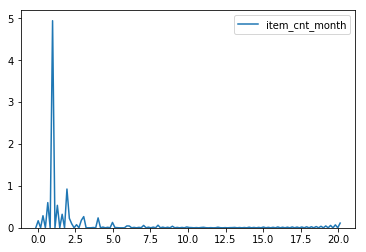

In [44]:
sns.kdeplot(train["item_cnt_month"])
plt.show()

### Mean Encodings
##### Make features such as total sale of each item last month, mean sale per item across all shops
##### Make features like total sale for each shop last month, mean sale per shop across all items